## Natural Language Autocomplete

In this notebook, we"re going to use transformers to get semantic suggestions for a given term.

In [4]:
import sys
sys.path.append("..")
from aips import *
from aips.spark import create_view_from_collection
import pandas
import pickle
import json
import tqdm
import spacy
import numpy
from spacy.matcher import Matcher
from IPython.display import display,HTML
from aips import get_engine
from pyspark.sql import SparkSession

engine = get_engine()
pandas.set_option("display.max_rows", 1000)
spark = SparkSession.builder.appName("AIPS").getOrCreate()

## Load and clean the Outdoors dataset

In [6]:
create_view_from_collection(engine.get_collection("outdoors"), "outdoors")
outdoors_dataframe = spark.sql("SELECT * from outdoors")
print(outdoors_dataframe.count())

18456


## Make a vocabulary of all the concepts in a corpus

In [7]:
nlp = spacy.load("en_core_web_sm")

## Listing 13.9

In [14]:
def normalize(span):
    return " ".join([token.lemma_.lower() for token in span])

def yield_tuple(dataframe, column, total):
    total = total or 100
    for idx, row in dataframe.iterrows():
        if idx < total:
            yield (row[column], idx)

def get_concepts(collection, source_field, total=None, load_from_cache=True):
    if load_from_cache:
        os.makedirs(os.path.dirname("../data/outdoors/outdoors_concepts.pickle"), exist_ok=True)
        with open("../data/outdoors/outdoors_concepts.pickle","rb") as fd:
            concepts = pickle.load(fd)
        with open("../data/outdoors/outdoors_labels.pickle","rb") as fd:
            labels = pickle.load(fd)
        return concepts,labels

    #Setting load_from_cache to False will bring you here
    print("Extracting concepts. This could take a while. Take a break and stretch :)")
    create_view_from_collection(collection, "concept_data")
    dataframe = spark.sql("SELECT * FROM concept_data")
        
    #Get all the noun and verb phrases in the content
    phrases = [] #All the normalized noun/verb phrases ("concepts") in the corpus
    sources = [] #The original text labels that was normalized to the concept
    
    #Use the spacy matcher to chunk patterns into concept labels
    #We don't need a full taxonomy graph extraction, just a vocabulary with term frequencies
    matcher = Matcher(nlp.vocab)
    nountags = ["NN", "NNP", "NNS", "NOUN"] #Nouns
    verbtags = ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ", "VERB"] #Verbs
    matcher.add("noun_phrases", [[{"TAG": {"IN": nountags},
                                   "IS_ALPHA": True, "OP": "+"}]])
    matcher.add("verb_phrases", [[{"TAG": {"IN": verbtags},
                                   "IS_ALPHA": True, "OP": "+",
                                   "LEMMA": {"NOT_IN": ["be"]}}]])
    for doc, _ in tqdm.tqdm(nlp.pipe(yield_tuple(dataframe, source_field, total),
                                     batch_size=40, n_threads=4, as_tuples=True),total=total):
        matches = matcher(doc)
        for _, start, end in matches:
            span = doc[start:end]
            phrases.append(normalize(span))
            sources.append(span.text)            
    
    #Aggregate the normalized concepts by term frequency
    concepts = {}
    labels = {}
    for i, phrase in phrases:
        if phrase not in concepts:
            concepts[phrase] = 0
            labels[phrase] = sources[i]
        concepts[phrase] += 1
    
    sorted_concepts = {k: v for k, v in sorted(concepts.items(), key=lambda item: item[1], reverse=True)}
    
    os.makedirs(os.path.dirname("../data/outdoors/outdoors_concepts.pickle"), exist_ok=True)
    with open("../data/outdoors/outdoors_concepts.pickle","wb") as fd:
        pickle.dump(sorted_concepts, fd)
    with open("../data/outdoors/outdoors_labels.pickle","wb") as fd:
        pickle.dump(labels, fd)
    
    return sorted_concepts, labels

## Listing 13.10

### Examining the vocabulary

What are the concepts with the highest frequency?

In [15]:
collection = engine.get_collection("outdoors")
concepts, labels = get_concepts(collection, "body",
                                load_from_cache=True)
topcons = {key: value for (key, value) in concepts.items() if value > 5}
print(f"Total number of labels: {len(labels.keys())}")
print(f"Total number of concepts: {len(concepts.keys())}")
print(f"Concepts with greater than 5 term frequency: {len(topcons.keys())}")
print(json.dumps(topcons, indent=2))

Total number of labels: 124366
Total number of concepts: 124366
Concepts with greater than 5 term frequency: 12375
{
  "have": 32782,
  "do": 26869,
  "use": 16793,
  "get": 13412,
  "go": 9899,
  "water": 9537,
  "make": 9476,
  "need": 7814,
  "time": 7187,
  "take": 6550,
  "find": 6359,
  "see": 5591,
  "rope": 5540,
  "know": 5522,
  "day": 5318,
  "way": 5239,
  "want": 5087,
  "people": 5083,
  "keep": 4789,
  "look": 4784,
  "area": 4548,
  "work": 4491,
  "thing": 4451,
  "try": 4179,
  "tent": 4095,
  "bag": 4054,
  "lot": 3934,
  "think": 3728,
  "trail": 3725,
  "say": 3669,
  "foot": 3606,
  "climb": 3559,
  "point": 3550,
  "place": 3539,
  "question": 3424,
  "help": 3206,
  "come": 3186,
  "put": 3115,
  "hike": 3042,
  "weight": 3034,
  "fall": 3027,
  "start": 3009,
  "leave": 2977,
  "answer": 2949,
  "give": 2945,
  "something": 2926,
  "food": 2907,
  "year": 2864,
  "carry": 2823,
  "pack": 2755,
  "end": 2752,
  "one": 2741,
  "bear": 2738,
  "fire": 2730,
  "bod

## Transformer time!

In [16]:
from sentence_transformers import SentenceTransformer, util as STutil
transformer = SentenceTransformer("roberta-base-nli-stsb-mean-tokens")
cache_name = "outdoors_embeddings"

## Listing 13.11

In [17]:
def get_embeddings(texts, cache_name, ignore_cache=False):
    cache_file_name = f"../data/embeddings/{cache_name}.pickle"
    if ignore_cache or not os.path.isfile(cache_file_name):
        embeddings = transformer.encode(texts)
        os.makedirs(os.path.dirname(cache_file_name), exist_ok=True)
        with open(cache_file_name, "wb") as fd:
            pickle.dump(embeddings, fd)
    else:
        with open(cache_file_name, "rb") as fd:
            embeddings = pickle.load(fd)
    return embeddings

In [18]:
#Note!  This is a hyperparameter.
#We are ignoring terms that occur less than this numner in the entire corpus.
#Lowering this number may lower precision
#Raising this number may lower recall
minimum_frequency = 6
phrases = [key for (key, tf) in concepts.items() if tf >= minimum_frequency]
#set ignore_cache=True to regenerate the embeddings rather than loading from the cache
embeddings = get_embeddings(phrases, cache_name, ignore_cache=False)

print(f"Number of embeddings: {len(embeddings)}")
print(f"Dimensions per embedding: {len(embeddings[0])}")

Number of embeddings: 12375
Dimensions per embedding: 768


## Listing 13.12

### Explore the top similarities for the top terms

In [23]:
def normalize_embedding(embedding):
    normalized = numpy.divide(embedding, numpy.linalg.norm(embedding))
    return list(map(float, normalized))

In [24]:
#Find the pairs with the highest cosine similarity scores
normalized_embeddings = list(map(normalize_embedding, embeddings))
similarities = STutil.dot_score(normalized_embeddings[0:250],
                                normalized_embeddings[0:505])
a_phrases = []
b_phrases = []
scores = []
for a in range(len(similarities) - 1):
    for b in range(a + 1, len(similarities)):
        a_phrases.append(phrases[a])
        b_phrases.append(phrases[b])
        scores.append(float(similarities[a][b]))
        
scores = pandas.DataFrame({"phrase a": a_phrases, "phrase b": b_phrases,
                           "score": scores, "name": "similarity"})
comparisons = scores.sort_values(by=["score"], ascending=False, ignore_index=True)
comparisons["idx"] = range(len(comparisons))
comparisons[comparisons["score"] > 0.7]

,phrase a,phrase b,score,name,idx
0,protect,protection,0.928151,similarity,0
1,climbing,climber,0.923570,similarity,1
2,camp,camping,0.878894,similarity,2
3,climb,climbing,0.833662,similarity,3
4,something,someone,0.821081,similarity,4
5,hike,hiking,0.815187,similarity,5
6,people,person,0.784663,similarity,6
7,climb,climber,0.782962,similarity,7
8,go,leave,0.770643,similarity,8
9,keep,stay,0.768611,similarity,9


## Listing 13.13

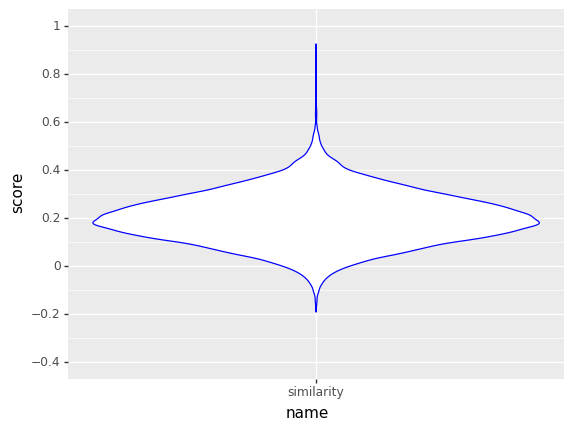

{<ggplot: (8729209273317)>}

In [ ]:
from plotnine import *
candidate_synonyms = comparisons[comparisons["score"] > 0.0]
{
    ggplot(comparisons, aes("name", "score")) + 
    geom_violin(color="blue") +
    scale_y_continuous(limits=[-0.4, 1.0],
                       breaks=[-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0])
}

## Listing 13.14

### Quickly matching vectors at query time

Now that we can get and compare concept embeddings, we need to be able to search these embeddings efficiently.

In [32]:
import nmslib
# initialize a new index, using a HNSW index on Dot Product
concepts_index = nmslib.init(method="hnsw", space="negdotprod")
normalized_embeddings = list(map(normalize_embedding, embeddings))
concepts_index.addDataPointBatch(normalized_embeddings)
concepts_index.createIndex(print_progress=True)

# Example query for the new index.  The 25th embedding is the term "bag"
ids, distances = concepts_index.knnQuery(normalized_embeddings[25], k=10)
matches = [labels[phrases[i]].lower() for i in ids]
print(matches)

['bag', 'bag ratings', 'bag cover', 'bag liner', 'garbage bags', 'wag bags', 'bag cooking', 'airbag', 'paper bag', 'tea bags']


## Listing 13.15

In [45]:
def print_labels(prefix,matches):
    display(HTML(f"<h4>Results for: <em>{prefix}</em></h4>"))
    for (l, d) in matches:
        print(str(int(d * 1000) / 1000), "|", l)
        
def embedding_search(index, query, phrases, k=20, min_similarity=0.75):
    matches = []
    query_embedding = transformer.encode(query)
    query_embedding = normalize_embedding(query_embedding)
    ids, distances = index.knnQuery(query_embedding, k=k)
    for i in range(len(ids)):
        distance = distances[i] * -1
        if distance > min_similarity:
            matches.append((phrases[ids[i]], distance))
    if not len(matches):
        matches.append((phrases[ids[1]], distances[1] * -1))
    return matches

def semantic_suggest(prefix):
    matches = embedding_search(concepts_index, prefix, phrases)
    print_labels(prefix, matches)

In [46]:
semantic_suggest("mountain hike")

1.0 | mountain hike
0.975 | mountain hiking
0.847 | mountain trail
0.787 | mountain guide
0.779 | mountain terrain
0.775 | mountain climbing
0.768 | mountain ridge
0.754 | winter hike


In [47]:
semantic_suggest("campfire")

1.0 | campfire
0.956 | camp fire
0.928 | campfire impact
0.865 | camping fuel
0.823 | camping stove
0.796 | camp stove
0.775 | cooking fire
0.774 | campground
0.764 | fireplace
0.759 | camping area
0.755 | have camp


In [48]:
semantic_suggest("dehyd")

0.941 | dehydrate
0.931 | dehydration
0.852 | rehydration
0.851 | dehydrator
0.836 | hydration
0.835 | hydrating
0.822 | rehydrate
0.812 | hydrate
0.788 | hydration pack
0.776 | hydration system


In [49]:
semantic_suggest("compa")

0.863 | comp
0.829 | compact
0.803 | compile
0.792 | compost
0.786 | compass
0.778 | competitor
0.765 | competence
0.758 | compactor
0.755 | compare


## Addendum: Bias Excercise
These cells enable exploration for detecting similarity/context bias that may exist in a model

In [ ]:
def build_candidate_set(cons):
    terms = list(cons.keys())
    originals = []
    candidates = []
    scores = []
    for term in tqdm.tqdm(terms[0:1000]):
        labels = embedding_search(concepts_index, term, phrases=terms, k=25)
        originals += [term] * len(labels)
        candidates += [l[0] for l in labels]
        scores += [l[1] for l in labels]
    pairs = pandas.DataFrame({"term": originals, "candidate": candidates, "score":scores})
    return pairs

In [ ]:
pairs = build_candidate_set(topcons)
pairs.to_csv("pairs.csv")

100%|██████████| 1000/1000 [00:17<00:00, 56.80it/s]


In [ ]:
#Compare a list of terms
def compare(terms):

    term_embeddings = transformer.encode(terms, convert_to_tensor=True)
    
    a_phrases = []
    b_phrases = []
    scores = []
    for a in range(len(terms) - 1):
        for b in range(a + 1, len(terms)):
            a_phrases.append(terms[a])
            b_phrases.append(terms[b])
            sim = STutil.pytorch_cos_sim(term_embeddings[a], term_embeddings[b])
            scores.append(float(sim))

    comparisons = pandas.DataFrame({"phrase a": a_phrases, "phrase b": b_phrases,
                                    "score": scores, "name": "similarity"})
    comparisons = comparisons.sort_values(by=["score"], ascending=False, ignore_index=True)
    return comparisons

In [ ]:
#Gender-occupational bias example
#Note the similarity scores for gender and occupation 
compare(["man","woman","nurse practitioner","doctor"])

,phrase a,phrase b,score,name
0,nurse practitioner,doctor,0.488934,similarity
1,man,woman,0.280403,similarity
2,woman,nurse practitioner,0.179482,similarity
3,man,doctor,0.084211,similarity
4,woman,doctor,0.028788,similarity
5,man,nurse practitioner,-0.030063,similarity


## Addendum: Vector Space Visualization
This cell uses Principal Component Analysis (PCA) to reduce embeddings to 3 dimensions so they can be plotted in 3d.

In [ ]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
vectors = embeddings.numpy()
pca = PCA(n_components=3)
pca_data = pca.fit_transform(vectors)

label_ids = []
label_texts = []
ids,_ = concepts_index.knnQuery(embeddings[100], k=5)
label_ids += [idx for idx in ids]
ids,_ = concepts_index.knnQuery(embeddings[505], k=5)
label_ids += [idx for idx in ids]
label_texts += [labels[phrases[idx]].lower() for idx in label_ids]
markers = ["v"]*len(vectors)

components = pandas.DataFrame({
    "x": pca_data[:,0],
    "y": pca_data[:,1],
    "z": pca_data[:,2]
})

ax = plt.figure(figsize=(24,16)).add_subplot(projection="3d")
ax.scatter(
    components["x"].values, 
    components["y"].values, 
    c=components["y"].values, 
    marker="v", 
    alpha=0.3
)

for i,label in zip(label_ids,label_texts):
    x = components["x"][i]
    y = components["y"][i]
    z = components["z"][i]
    zdir = "y"
    ax.text(x, y, z, label, zdir)

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
ax.set_xlabel("PCA X Label")
ax.set_ylabel("PCA Y Label")
ax.set_zlabel("PCA Z Label")
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

## Addendum: Find topic vector centroids with KMeans

In [ ]:
from torch import stack as  torch_stack
from sklearn.cluster import KMeans

def semanticnearest(embeddings,k=20):
    matches = []
    ids, distances = concepts_index.knnQuery(embeddings, k=k)
    for i in range(len(ids)):
        text = phrases[ids[i]]
        dist = distances[i] * -1
        if dist>0.6:
            matches.append((ids[i], text, dist))
    if not len(matches):
        matches.append(([ids[1]], phrases[ids[1]], dist))
    return matches

In [ ]:
def findcentroids(embeddings, n_clusters=8, max_iter=300):
    centroids = []
    centroid_embeddings = []
    vectors = embeddings.numpy()
    kmeans = KMeans(n_clusters=n_clusters, random_state=505, max_iter=max_iter).fit(vectors)
    for centroid in kmeans.cluster_centers_:
        matches = semanticnearest(centroid,k=5)
        centroids.append(matches[0])
        centroid_embeddings.append(embeddings[matches[0][0]])
        display(HTML(f"<h4>Results for: <em> centroid {str(len(centroids)-1)}</em></h4>"))
        for i,l,d in matches:
            if l in labels.keys():
                l = labels[l].lower()
            print(str(i) + "\t" + l + "\t" + str(d))
    
    return centroids,torch_stack(centroid_embeddings)

In [ ]:
centroids, centroid_embeddings = findcentroids(embeddings, n_clusters=100,  max_iter=50)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


10466	handwashing	0.8039088249206543
11868	dishwashing	0.793239414691925
7146	scrubbing	0.7859534621238708
360	washing	0.7750263810157776
10465	rinsing	0.7744348645210266


150	backpack	0.7895638942718506
11361	kg backpack	0.7825618982315063
3707	pack weight	0.7769227027893066
7231	load bearing	0.7743254899978638
3757	packaging	0.761772632598877


80	ice	0.8592485189437866
3071	ice axes	0.8468809127807617
8369	icefall	0.8263386487960815
6675	icebreaker	0.8123111128807068
11032	ice box	0.7928193807601929


11915	canvas tarp	0.722813606262207
10264	tarptent	0.7217321395874023
298	tarps	0.7082759141921997
9696	trapezoid	0.6990887522697449
10792	tarpaulin	0.6989172101020813


1880	in	0.7571237087249756
2183	ii	0.7470230460166931
4185	nz	0.7375406622886658
4462	iso	0.7188642024993896
2624	i	0.7164528965950012


6103	sw	0.8860063552856445
11432	swinging	0.8552279472351074
493	swim	0.8510957956314087
10037	swipe	0.8360576629638672
10922	swift	0.8324984908103943


1852	d	0.8285518884658813
4547	dent	0.8273959159851074
7002	delorme	0.8123890161514282
11542	dnt	0.8116810321807861
9735	duo	0.795647144317627


2602	n	0.8527299761772156
7539	ne	0.8338150978088379
11971	nestled	0.7767168283462524
4107	ny	0.7763041257858276
10024	nts	0.775598406791687


8521	plateaus	0.7569299936294556
11700	kluane	0.7120229601860046
8288	luke	0.7050638794898987
9895	plaque	0.7036221027374268
7223	laurel	0.699063777923584


6062	weather changes	0.8357369899749756
1997	weather conditions	0.8313697576522827
109	weather	0.8300240635871887
2697	weather forecast	0.8299533128738403
2728	wind chill	0.8286075592041016


4103	insight	0.8352082371711731
5620	viewing	0.8058109283447266
7240	eyesight	0.8054004311561584
9587	viewer	0.8003820776939392
6219	watching	0.7742598056793213


3763	ass	0.7401955127716064
1954	assist	0.7372340559959412
2688	aa	0.7091929912567139
11340	assateague	0.7038854360580444
982	a	0.6984075307846069


8926	has taught	0.7313310503959656
3964	educate	0.7305005788803101
3669	learning	0.724667489528656
192	learn	0.7245075106620789
4060	tutorial	0.721176028251648


12166	wren	0.8052818775177002
719	wax	0.7937995791435242
10215	waxing	0.7909773588180542
2245	w	0.7888602018356323
1995	wales	0.7764984369277954


10456	nice	0.8788074254989624
3488	brightness	0.8251219391822815
7327	perfect	0.8171699047088623
369	clean	0.8108123540878296
1713	good	0.8085874319076538


7202	moisture content	0.8020135164260864
442	moisture	0.7990432977676392
11551	moisturise	0.7880430221557617
6266	moisten	0.7833759784698486
9493	moisturizing	0.7803248167037964


9900	pipistrelle	0.8525463342666626
4355	polypro	0.8172390460968018
10575	pooping	0.817082405090332
8932	pus	0.8134660720825195
3104	pistols	0.8046128153800964


7229	base weight	0.7779852747917175
446	biking	0.7684118747711182
11522	bicycling	0.7644389867782593
1657	base layer	0.7538042664527893
9462	bending	0.7347290515899658


9957	water boat	0.8313672542572021
2953	sea kayak	0.8215214014053345
9956	water kayak	0.8073369264602661
10464	scuba dive	0.7997897267341614
3552	scuba diving	0.7944430112838745


4020	daytime	0.8735556602478027
14	day	0.8605858683586121
10871	day time	0.8601269721984863
5503	summer day	0.8512469530105591
11375	day activities	0.8326908349990845


4866	discontinued	0.8149714469909668
1968	dispose	0.8117832541465759
4747	demo	0.8004209399223328
2589	decline	0.7989648580551147
2616	drawbacks	0.7943227887153625


9994	caverns	0.7767986059188843
3471	concealed	0.7743202447891235
5466	cork	0.7523952722549438
11531	cary	0.7515003681182861
5081	cocoon	0.7495299577713013


6603	retirement	0.8234813213348389
7421	have ended	0.8102874159812927
50	end	0.8030652403831482
9333	ending	0.7983051538467407
9586	retie	0.7965340614318848


1538	spine	0.8231596946716309
3987	spices	0.8197779655456543
9471	ski slope	0.7990498542785645
153	skiing	0.7701194286346436
11134	ssp	0.7665972709655762


8227	strangled	0.7923411726951599
8398	entangled	0.7890533208847046
2190	tangled	0.7881778478622437
3692	dangling	0.7488107681274414
8726	diameter rope	0.707449734210968


18	keep	0.8597937822341919
8297	keeping	0.806671142578125
570	maintain	0.7947790026664734
7310	keep doing	0.7896531820297241
1951	help keep	0.7882221937179565


52	bears	0.9547189474105835
8149	bear territory	0.9102210402488708
6637	bear boxes	0.886967122554779
2144	bear country	0.8867158889770508
4493	bear attacks	0.8701561689376831


8363	revised	0.7949817180633545
2927	approved	0.7847862839698792
721	re	0.7840685844421387
6968	revive	0.7646567225456238
9766	reclaimed	0.7610362768173218


255	rescue	0.8580117225646973
8199	rescue situations	0.8480336666107178
9058	rescue work	0.8338305950164795
5733	rescue operation	0.8193408250808716
4987	rescue service	0.8092625737190247


6847	thomas	0.7790185213088989
7241	teton	0.7127286195755005
2522	topo map	0.7104122638702393
7983	tautline	0.7098302245140076
11062	tooth paste	0.7090297341346741


59	snow	0.912587583065033
3809	snowfall	0.9062578678131104
9459	snow level	0.9016374349594116
4232	snow conditions	0.893771767616272
6660	snow cover	0.8778385519981384


7038	emergency use	0.8193007707595825
11104	emergency supplies	0.788354754447937
287	emergency	0.7775496244430542
10385	energy expenditure	0.7605517506599426
274	energy	0.7545884251594543


157	light	0.8936519622802734
1109	sunlight	0.8919165730476379
927	lightning	0.8895128965377808
2296	lighting	0.8709940910339355
11942	sun light	0.8631349802017212


5610	camping area	0.943703293800354
4416	camping sites	0.939818263053894
10206	camping place	0.9382578134536743
101	camping	0.938123345375061
4735	camping spot	0.9285566806793213


1403	garment	0.8328847885131836
6972	gadget	0.8292560577392578
8974	gaia gps	0.8038685321807861
2398	garage	0.7970733642578125
11990	garmin gpsmap	0.7960401773452759


5277	overloading	0.8217323422431946
11355	large	0.8041853308677673
7012	overdo	0.784658670425415
2362	high	0.7797483801841736
10796	overhead	0.7774761915206909


4663	gr	0.7909327149391174
12260	gander	0.7863974571228027
2865	gauge	0.7751128077507019
641	g	0.77402663230896
2195	vegetables	0.7726103663444519


1112	s	0.8231701850891113
2800	sar	0.7646641135215759
11891	sq	0.7381620407104492
6519	sss	0.7290431261062622
4283	st	0.7285756468772888


4080	interpretations	0.7884485721588135
866	considerations	0.773186445236206
10565	misinterpreted	0.7678906917572021
5079	speculation	0.7643787264823914
2633	confusion	0.7578399181365967


5	water	0.9379384517669678
9093	watering	0.9307310581207275
7458	water systems	0.927438497543335
2929	water temperatures	0.8996999263763428
8322	water filtration	0.8940558433532715


2098	e	0.7974430322647095
2413	extension	0.7970150709152222
11210	eluded	0.7882934808731079
6252	excel	0.787533164024353
2175	exerting	0.780057966709137


5292	compact	0.8281096816062927
1081	compress	0.8203670978546143
345	compass	0.7968421578407288
6117	compiled	0.7791554927825928
10502	compactor	0.7683169841766357


10932	geotagged	0.8327405452728271
2885	georgia	0.8044118881225586
3309	og	0.7982532978057861
3883	genera	0.7966659069061279
10019	geotags	0.7872018814086914


2606	relationship	0.8243179321289062
187	couple	0.8233011364936829
4838	couple years	0.7956576943397522
10207	in knot	0.7919073104858398
4754	couple times	0.7833035588264465


6035	wildland	0.8433859944343567
2033	wilderness area	0.8398216962814331
10394	wild country	0.8342101573944092
2080	national forest	0.8290162086486816
309	wilderness	0.824763834476471


183	safety	0.9390150904655457
5101	safety precaution	0.934195876121521
9273	safety aspect	0.9272300004959106
6378	safety measures	0.9146923422813416
8175	safety factor	0.9097393751144409


60	climbing	0.9190400242805481
4160	climbing wall	0.8909657001495361
6205	climbing grades	0.8877271413803101
8884	climbing style	0.8792374134063721
9219	climbing trip	0.8776151537895203


6684	trail system	0.821201741695404
8176	trails	0.7960073947906494
6527	trail map	0.7891558408737183
6182	trad routes	0.7864116430282593
28	trail	0.7837966680526733


12055	oxygen bottles	0.7924849987030029
901	water bottles	0.7876468896865845
6776	pop bottles	0.7790521383285522
6929	spray bottle	0.772118866443634
9303	squeeze bottle	0.7709910273551941


881	have had	0.8096016645431519
0	have	0.8093082904815674
941	have done	0.7939944267272949
6587	seen have	0.7887260913848877
11959	remember having	0.7843338251113892


169	fish	0.8696480393409729
7971	fish hooks	0.8096451759338379
3517	fishing line	0.8089680671691895
427	fishing	0.8016319870948792
4675	fishing license	0.7978147864341736


46	food	0.8715711236000061
10547	food preparation	0.8597918748855591
7376	food items	0.8457167148590088
8240	food prep	0.8261338472366333
11722	food pack	0.8217974901199341


2851	softshells	0.7811945676803589
8933	softshells	0.7589210271835327
8279	goretex layer	0.7395590543746948
11956	goretex jacket	0.7379781007766724
10880	nylon shell	0.737114429473877


613	trouble	0.7718040943145752
65	problem	0.7518213391304016
8607	bear problems	0.744933009147644
5130	shame	0.7372564077377319
11151	get sucked	0.7278239130973816


1128	t	0.8834911584854126
24	tent	0.867566704750061
8745	tent design	0.8632591962814331
8683	tent material	0.8592126965522766
11022	tso	0.8551743030548096


3075	monoxide	0.7704377770423889
443	metals	0.7185393571853638
6088	puma	0.7170676589012146
7844	metal box	0.7164843082427979
11076	plastic sheet	0.7156269550323486


356	notice	0.738502025604248
1542	consequences	0.7304048538208008
2160	certification	0.7300781607627869
4911	documentation	0.728556215763092
2846	verify	0.7186385989189148


1718	shotgun	0.9232792854309082
6615	gunshot	0.9028828144073486
742	guns	0.8919997811317444
7451	shotgun shells	0.8612033128738403
688	shots	0.8386603593826294


41	start	0.9466565251350403
4157	have started	0.9240562915802002
4170	get started	0.9216912984848022
1958	starting	0.911064863204956
578	begins	0.904431164264679


84	mountains	0.9453151226043701
11653	mountain region	0.9305295348167419
5184	mountain national	0.9161891937255859
6987	mountain area	0.9146012663841248
7808	mountain project	0.8997241258621216


785	carbon	0.8243679404258728
7250	carbonate	0.7912795543670654
10635	coconut shell	0.7700209617614746
867	crevasse	0.7428835034370422
2182	coconut	0.7381671071052551


976	observe	0.7917811870574951
7547	overestimate	0.7675182223320007
1233	o	0.7668154239654541
5426	o o	0.7534312605857849
11454	inyo	0.7503266334533691


90	temperature	0.8548049330711365
9223	temperature conditions	0.8398942947387695
3460	temperature rating	0.8196693658828735
3287	temperature range	0.8154594898223877
4606	temperature changes	0.8032923936843872


30	feet	0.8061261177062988
6570	walking shoes	0.794042706489563
4594	walking boots	0.7911736965179443
6485	foot placement	0.7886850833892822
1024	footwear	0.7789327502250671


1396	r	0.821674108505249
721	re	0.793954610824585
8792	rab	0.7757265567779541
4089	reps	0.7754067182540894
12307	reserved	0.7692046165466309


1439	l	0.8517394661903381
7223	laurel	0.8233407735824585
1414	lens	0.8045949935913086
5528	lukla	0.7783592343330383
10929	laos	0.7635170221328735


3472	k	0.8165992498397827
7389	ken	0.7848976254463196
11750	karen	0.751146674156189
4272	kettle	0.7409043312072754
3358	trekkers	0.7387648224830627


636	new	0.854458212852478
4783	newbies	0.7979802489280701
6521	newt	0.7955257296562195
1226	beginner	0.7844929695129395
5542	newton	0.7766983509063721


257	m	0.8446632623672485
542	mm	0.8423643112182617
1528	mid	0.7872714996337891
9545	midway	0.7546294331550598
6851	multi	0.7532086372375488


1402	v	0.8630764484405518
5870	va	0.8466918468475342
1502	valve	0.8247615098953247
2139	van	0.8171823620796204
704	uv	0.8110509514808655


691	rubber	0.7543233633041382
1987	binoculars	0.7469301819801331
9204	rubble	0.746375322341919
2349	nutrient	0.7452141046524048
2647	crabbing	0.7335491180419922


539	f	0.8480340838432312
12051	fcrf	0.8246493935585022
7175	fusion	0.8041552305221558
8001	ferns	0.7878701686859131
4221	fir	0.7850615978240967


3123	rocker	0.8058731555938721
63	rock	0.8044183254241943
8792	rab	0.8032640218734741
7849	rock type	0.8026611804962158
5457	roaring	0.8007950186729431


5619	buying	0.7884133458137512
685	purchasing	0.7506146430969238
4422	buyer	0.7389868497848511
7334	price tag	0.7307461500167847
110	buying	0.7270240187644958


898	b	0.8516513705253601
3854	bob	0.8261837959289551
11190	ba	0.8200526833534241
6818	basal	0.8190156817436218
3496	basin	0.8104143142700195


5319	ve slept	0.7964910268783569
62	sleeping	0.7938579320907593
5775	silence	0.7934814691543579
10115	sleeping area	0.7851721048355103
2313	retreating	0.7754265666007996


2660	dispersed	0.9178917407989502
1750	get rid	0.9033929705619812
2838	let go	0.8993656039237976
3344	displaced	0.8967552185058594
5593	disregard	0.882993221282959


11220	wy	0.8337205648422241
11890	whitening	0.8113100528717041
10517	whine	0.8112365007400513
2245	w	0.8086672425270081
802	west	0.8014295697212219


8189	diffusion	0.8517155647277832
12086	transducers	0.8138809204101562
6899	diffuse	0.8019018173217773
10667	distort	0.7982432246208191
11271	diffuser	0.7924349904060364


6567	increments	0.803624153137207
205	increased	0.8034881353378296
3891	succeed	0.7910184264183044
947	advise	0.7838099598884583
3651	enhance	0.7767338752746582


8051	subsets	0.7899445295333862
2615	segment	0.7785001993179321
3822	slit	0.7766700983047485
1112	s	0.7720757126808167
2275	se	0.7666401863098145


6377	czech	0.8028873205184937
262	c	0.790820837020874
6268	camber	0.7687990665435791
3171	cdc	0.7612237334251404
706	core	0.7513589262962341


136	rain	0.9595921039581299
6100	rainstorm	0.9305990934371948
3400	rainfall	0.9249914884567261
7807	rain storm	0.9163528680801392
2268	rain jacket	0.9074798226356506


53	fire	0.9285263419151306
8855	fire risk	0.8601168990135193
9178	fire way	0.850631833076477
1404	firearm	0.8404016494750977
2957	burning	0.8364914655685425


1512	extent	0.822136640548706
2722	evolved	0.8076997399330139
1321	expands	0.8045869469642639
2413	extension	0.7999024987220764
10186	outward	0.7792891263961792


365	survival	0.9313869476318359
11079	survival scenario	0.9306722283363342
6385	survivalist	0.925033450126648
1498	survival situation	0.9190427660942078
9183	survival techniques	0.9152107238769531


76	heat	0.8535789847373962
8423	reheat	0.8358451128005981
4508	heat energy	0.82271409034729
4831	heat stroke	0.8222683668136597
9172	heat index	0.8204110264778137


3292	household	0.8434160947799683
579	house	0.8372502326965332
378	home	0.8117220997810364
9971	home range	0.7668390274047852
6759	residences	0.7395430207252502


278	north	0.8588919639587402
1759	northern	0.8299272656440735
3848	north face	0.8177759647369385
9633	north ridge	0.7910661101341248
5480	north star	0.7895592451095581


2361	flavors	0.8203893303871155
7036	fl	0.8198474049568176
3120	flavour	0.8093882203102112
1738	flares	0.7932642698287964
2976	flour	0.7854904532432556


9126	stabilization	0.7743051052093506
1405	acclimatization	0.7705481052398682
3532	clearing	0.7671659588813782
2581	stabilizes	0.7657316327095032
3873	acclimatisation	0.7636595964431763


11720	meetup	0.771183967590332
615	meet	0.7508147954940796
9886	groupings	0.7472021579742432
7582	has gathered	0.738388180732727
160	group	0.7334408760070801


4003	bacon	0.8155540227890015
1199	beacon	0.8110179305076599
3410	barb	0.7795612812042236
3230	boston	0.7717463970184326
10021	broach	0.7702921628952026


10921	proper	0.8207600712776184
2983	p	0.8051226139068604
5403	purcell	0.7904654741287231
4872	piston	0.7866733074188232
8285	prevalence	0.7812260389328003


5603	air space	0.855431318283081
3081	aircrafts	0.8263689875602722
95	air	0.822013795375824
2723	airplanes	0.8155893087387085
7828	air force	0.8134362697601318


5489	rope length	0.8312198519706726
12	rope	0.829969048500061
11447	rope systems	0.826654314994812
12141	rope friction	0.7911919951438904
8799	rope strength	0.7817515730857849


1928	h	0.8281552791595459
10503	hutte	0.800692081451416
4827	hace	0.7798982858657837
7088	hwy	0.7708567380905151
11818	hasten	0.7647088766098022


11587	hiking paths	0.9325955510139465
93	hiking	0.9240505695343018
1701	hiking trails	0.9238235950469971
8955	hiking routes	0.9081542491912842
3025	hiking trip	0.8992125988006592


6763	contraction	0.8053606748580933
5128	contour lines	0.8053369522094727
2484	contour	0.8011815547943115
6581	contemplate	0.7963125109672546
1678	contrasting	0.7873033881187439


5537	telephone	0.8746819496154785
3360	cellphone	0.8537193536758423
377	phone	0.8536425828933716
6789	cell phone coverage	0.8482431173324585
1747	cell phone	0.8477216958999634


In [ ]:
print(centroids)
print(centroid_embeddings)

[(10466, 'handwash', 0.8039088249206543), (150, 'backpack', 0.789563775062561), (80, 'ice', 0.8592484593391418), (11915, 'canvas tarp', 0.722813606262207), (1880, 'in', 0.7571237087249756), (6103, 'sw', 0.8860063552856445), (1852, 'd', 0.8285518884658813), (2602, 'n', 0.8527299761772156), (8521, 'plateaus', 0.756929874420166), (6062, 'weather change', 0.8357369899749756), (4103, 'insight', 0.8352082371711731), (3763, 'ass', 0.7401955127716064), (8926, 'have teach', 0.7313310503959656), (12166, 'wren', 0.8052818775177002), (10456, 'nice', 0.8788074851036072), (7202, 'moisture content', 0.8020135164260864), (9900, 'pipistrelle', 0.8525463342666626), (7229, 'base weight', 0.7779852747917175), (9957, 'water boat', 0.8313672542572021), (4020, 'daytime', 0.8735556602478027), (4866, 'discontinue', 0.8149714469909668), (9994, 'cavern', 0.7767986059188843), (6603, 'retirement', 0.8234813213348389), (1538, 'spine', 0.8231596946716309), (8227, 'strangle', 0.7923411726951599), (18, 'keep', 0.85979

In [ ]:
from sentence_transformers import util as STutil
normalized_centroid_embeddings = list(map(normalize_embedding, embeddings))
similarities = STutil.dot_score(normalized_centroid_embeddings, normalized_centroid_embeddings)
print("The shape of the resulting similarities:", similarities.shape)

The shape of the resulting similarities: torch.Size([100, 100])


### KMeans Topic distribution

This cell below shows good distribution of similarity scores for our topics.

In [ ]:
import pandas

a_phrases = []
b_phrases = []
scores = []

for a in range(len(similarities)-1):
    for b in range(a+1, len(similarities)):
        a_phrases.append(centroids[a][1])
        b_phrases.append(centroids[b][1])
        scores.append(float(similarities[a][b]))

df = pandas.DataFrame({"phrase a": a_phrases, "phrase b": b_phrases, "score":scores})
df.sort_values(by=["score"], ascending=False, ignore_index=True)

,phrase a,phrase b,score
0,revise,increment,0.723681
1,wren,wy,0.713014
2,b,bacon,0.671149
3,temperature,heat,0.666397
4,start,new,0.664019
...,...,...,...
4945,sw,monoxide,-0.149354
4946,camping area,t,-0.173272
4947,camping area,oxygen bottle,-0.177567
4948,start,have sleep,-0.190825


Up next: [Semantic Search with Dense Vector Embeddings](4.semantic-search.ipynb)